### Neural Network Fitting and Cognitive Theory Analysis

This script uses a PyTorch neural network to fit a noisy cosine curve, aiming to create and analyze the phenomena of "underfitting," "good fitting," and "overfitting."

**Core Highlights:**

1.  Uses neural network models of varying complexity to correspond to the three fitting states.
2.  For each trained model, it employs the `PathIntegralAnalyzer` to calculate the **Cognitive Internal Energy (U)** and **Entropy (S)** metrics based on the latest path integral physics theory.
3.  Visualizes the model's fitting performance alongside the theoretical analysis metrics, intuitively demonstrating the relationship between the model's external behavior and its internal structural measurements.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import copy
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Data Preparation ---
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X_np = np.sort(np.random.rand(n_samples))
y_np = true_fun(X_np) + np.random.randn(n_samples) * 0.1

# Convert to PyTorch Tensors
X_tensor = torch.FloatTensor(X_np).unsqueeze(1)
y_tensor = torch.FloatTensor(y_np).unsqueeze(1)

In [7]:
# --- 2. Neural Network Model Definition ---
class RegressionMLP(nn.Module):
    """A Multi-Layer Perceptron for regression tasks."""
    def __init__(self, layer_sizes):
        super(RegressionMLP, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [8]:
# --- 3. Path Integral Physics Theory Analyzer ---
class PathIntegralAnalyzer:
    """
    Analyzes a neural network based on the path integral physics theory.
    Calculates Cognitive Internal Energy (U) and Entropy (S).
    - Grounding Node: The single output node of the regression model.
    - Graph Construction: Can handle any number of layers in the RegressionMLP.
    """
    def __init__(self, model):
        model_copy = copy.deepcopy(model)
        self.model = model_copy.to('cpu')
        self.linear_layers = [l for l in self.model.layers if isinstance(l, nn.Linear)]
        self.graph = self._build_graph()
        # For a regression task, the grounding node is the unique output node
        self.grounding_nodes = {f"{len(self.linear_layers)}-0"}
        self.hidden_nodes = self._get_hidden_nodes()
        self.memoized_paths = {}

    def _build_graph(self):
        G = nx.DiGraph()
        # Input layer nodes
        for i in range(self.linear_layers[0].in_features):
            G.add_node(f"0-{i}", layer=0)
        # Hidden and output layer nodes
        for i, l in enumerate(self.linear_layers):
            for j in range(l.out_features):
                G.add_node(f"{i+1}-{j}", layer=i+1)
            weights = torch.abs(l.weight.data.t())
            probs = torch.softmax(weights, dim=1)
            for u in range(l.in_features):
                for v in range(l.out_features):
                    p = probs[u, v].item()
                    if p > 1e-9:
                        # Cost represents the energy of propagating along an edge
                        G.add_edge(f"{i}-{u}", f"{i+1}-{v}", cost=1.0 - np.log(p))
        return G

    def _get_hidden_nodes(self):
        # Hidden nodes are all nodes except the input (0) and output (len) layers
        num_layers = len(self.linear_layers)
        return [n for n, d in self.graph.nodes(data=True) if 0 < d['layer'] < num_layers]

    def find_all_paths_dfs(self, start, targets):
        memo_key = (start, tuple(sorted(list(targets))))
        if memo_key in self.memoized_paths: return self.memoized_paths[memo_key]

        paths, stack = [], [(start, [start], 0)]
        while stack:
            curr, path, cost = stack.pop()
            if curr in targets:
                paths.append({'path': path, 'cost': cost})
                continue
            if len(path) > (len(self.linear_layers) + 2): continue # Limit path depth
            for neighbor in self.graph.neighbors(curr):
                if neighbor not in path:
                    stack.append((neighbor, path + [neighbor], cost + self.graph[curr][neighbor]['cost']))
        self.memoized_paths[memo_key] = paths
        return paths

    def calculate_metrics_for_node(self, node):
        paths = self.find_all_paths_dfs(node, self.grounding_nodes)
        if not paths: return float('inf'), float('inf')

        costs = np.array([p['cost'] for p in paths])
        
        # Cognitive Internal Energy (U) - Harmonic mean of path energies (costs)
        conductances = 1.0 / (costs + 1e-9)
        U = 1.0 / np.sum(conductances) if np.sum(conductances) > 0 else float('inf')

        # Entropy (S) - Shannon entropy of path importances
        importances = np.exp(-1.0 * costs)
        groundingness = np.sum(importances)
        probabilities = importances / groundingness if groundingness > 0 else []
        if probabilities.size > 0:
             S = -np.sum(probabilities * np.log2(probabilities + 1e-9))
        else:
            S = float('inf')

        return U, S

    def analyze(self):
        U_vals, S_vals = [], []
        if not self.hidden_nodes: return 0, 0 # If no hidden layers, metrics are zero

        # Analyze all hidden nodes
        for node in tqdm(self.hidden_nodes, desc=f"Analyzing Cognitive Metrics", leave=False):
            U, S = self.calculate_metrics_for_node(node)
            if np.isfinite(U) and np.isfinite(S):
                U_vals.append(U)
                S_vals.append(S)

        avg_U = np.mean(U_vals) if U_vals else 0
        avg_S = np.mean(S_vals) if S_vals else 0
        return avg_U, avg_S

In [9]:
# --- 4. Main Training and Analysis Workflow ---

# Define three experimental configurations
model_configs = {
    "Underfitting": {
        "layers": [1, 5, 3, 1],  # Simple structure
        "epochs": 1000,
        "lr": 0.01
    },
    "Good Fit": {
        "layers": [1, 64, 64, 1], # Moderately complex model
        "epochs": 5000,
        "lr": 0.01
    },
    "Overfitting": {
        "layers": [1, 128, 128, 128, 1], # Very complex model
        "epochs": 40000, # Train for a very long time
        "lr": 0.001
    }
}

results = {}

# Train and analyze
for name, config in model_configs.items():
    print(f"--- Training Model for: {name} ---")
    model = RegressionMLP(config["layers"])
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.MSELoss()

    for epoch in tqdm(range(config["epochs"]), desc=f"Training {name}"):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

    # Analyze after training
    analyzer = PathIntegralAnalyzer(model)
    avg_U, avg_S = analyzer.analyze()

    # Save results
    results[name] = {
        "model": model,
        "loss": loss.item(),
        "U": avg_U,
        "S": avg_S
    }
    print(f"Final Loss: {loss.item():.4f}, Avg Cognitive Internal Energy (U): {avg_U:.4f}, Avg Entropy (S): {avg_S:.4f}\n")

--- Training Model for: Underfitting ---


Training Underfitting: 100%|██████████| 1000/1000 [00:01<00:00, 925.56it/s]


Final Loss: 0.0587, Avg Cognitive Internal Energy (U): 1.0229, Avg Entropy (S): 0.9609

--- Training Model for: Good Fit ---


Training Good Fit: 100%|██████████| 5000/5000 [00:05<00:00, 862.76it/s]


Final Loss: 0.0063, Avg Cognitive Internal Energy (U): 0.5483, Avg Entropy (S): 2.9644

--- Training Model for: Overfitting ---


Training Overfitting: 100%|██████████| 40000/40000 [01:08<00:00, 588.17it/s]
                                                                               

Final Loss: 0.0000, Avg Cognitive Internal Energy (U): 0.3515, Avg Entropy (S): 6.9022



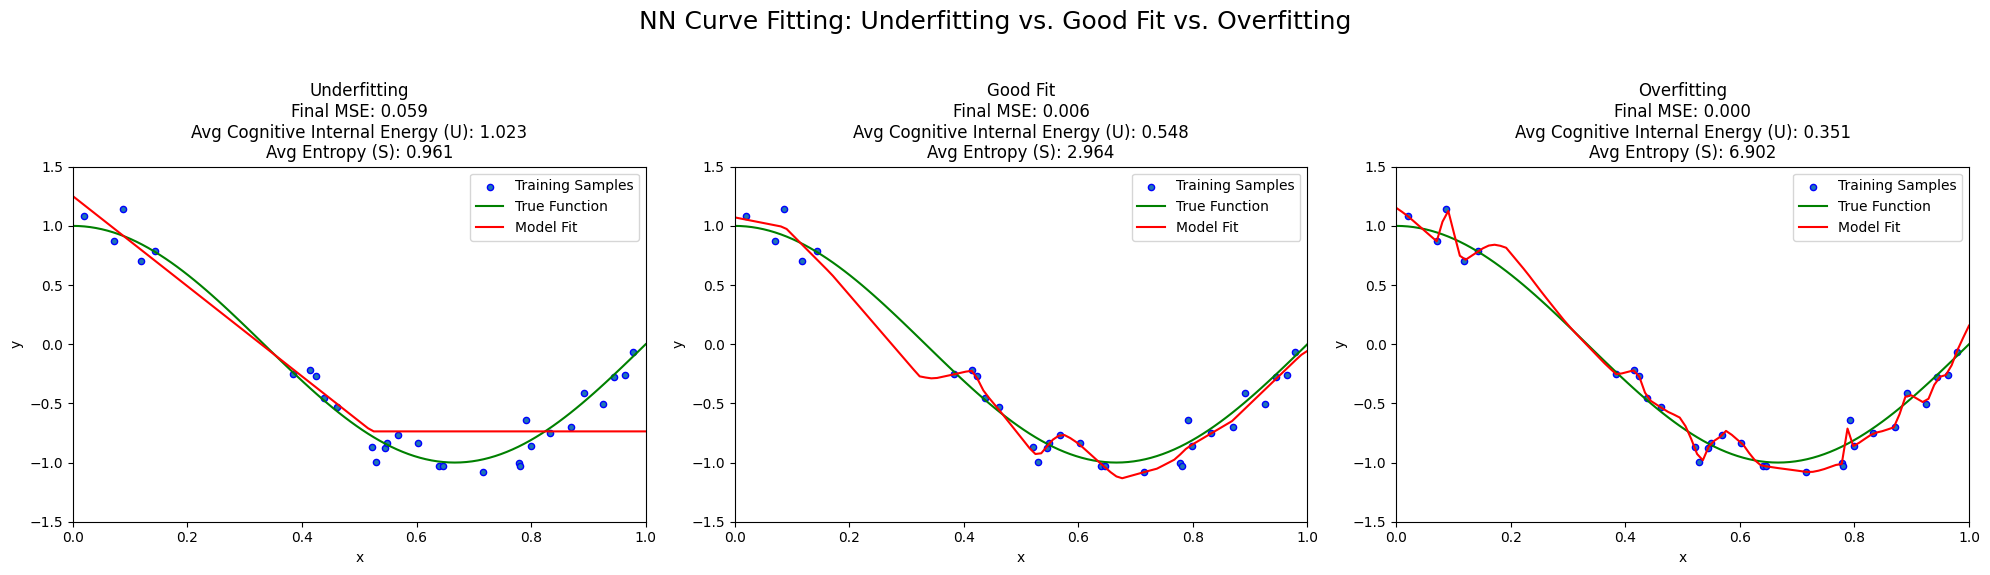

In [10]:
# --- 5. Visualization ---
plt.figure(figsize=(20, 6))
plt.suptitle("NN Curve Fitting: Underfitting vs. Good Fit vs. Overfitting", fontsize=18)

for i, name in enumerate(model_configs.keys()):
    ax = plt.subplot(1, 3, i + 1)
    model = results[name]["model"]

    # Prepare test data for plotting the curve
    X_test = torch.FloatTensor(np.linspace(0, 1, 100)).unsqueeze(1)
    with torch.no_grad():
        y_pred = model(X_test)

    # Plotting
    ax.scatter(X_np, y_np, edgecolor="b", s=20, label="Training Samples")
    ax.plot(np.linspace(0, 1, 100), true_fun(np.linspace(0, 1, 100)), 'g-', label="True Function")
    ax.plot(X_test.numpy(), y_pred.numpy(), 'r-', label="Model Fit")

    ax.set_xlim((0, 1))
    ax.set_ylim((-1.5, 1.5))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

    # Display all metrics in the title
    title_text = (
        f"{name}\n"
        f"Final MSE: {results[name]['loss']:.3f}\n"
        f"Avg Cognitive Internal Energy (U): {results[name]['U']:.3f}\n"
        f"Avg Entropy (S): {results[name]['S']:.3f}"
    )
    ax.set_title(title_text, fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()